## Block 1: Rayleigh Fading Channel

This block simulates a Rayleigh fading channel for a 64-subcarrier OFDM system. We visualize:
- Channel magnitude per subcarrier
- Rayleigh envelope distribution

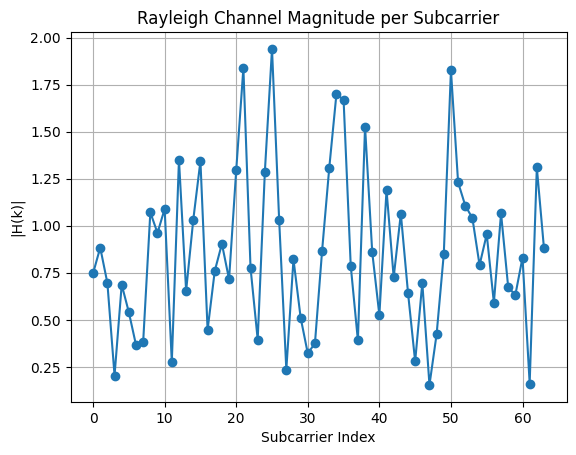

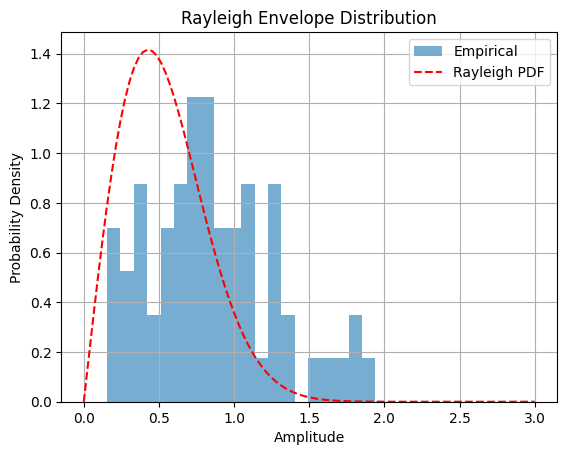

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rayleigh

N_sub = 64
h = (np.random.randn(N_sub) + 1j*np.random.randn(N_sub)) / np.sqrt(2)

# Channel magnitude
plt.figure()
plt.plot(np.abs(h), marker='o')
plt.title("Rayleigh Channel Magnitude per Subcarrier")
plt.xlabel("Subcarrier Index")
plt.ylabel("|H(k)|")
plt.grid(True)
plt.savefig("Block1_channel_magnitude.png", dpi=300)
plt.show()

# Rayleigh PDF
samples = np.abs(h)
x = np.linspace(0, 3, 100)
pdf = rayleigh.pdf(x, scale=np.std(samples))
plt.figure()
plt.hist(samples, bins=20, density=True, alpha=0.6, label="Empirical")
plt.plot(x, pdf, 'r--', label="Rayleigh PDF")
plt.title("Rayleigh Envelope Distribution")
plt.xlabel("Amplitude")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.savefig("Block1_rayleigh_pdf.png", dpi=300)
plt.show()

## Block 2: Pilot Design in OFDM

We insert comb-type pilots and interpolate the channel using linear and spline methods. This shows how pilot placement affects estimation accuracy.

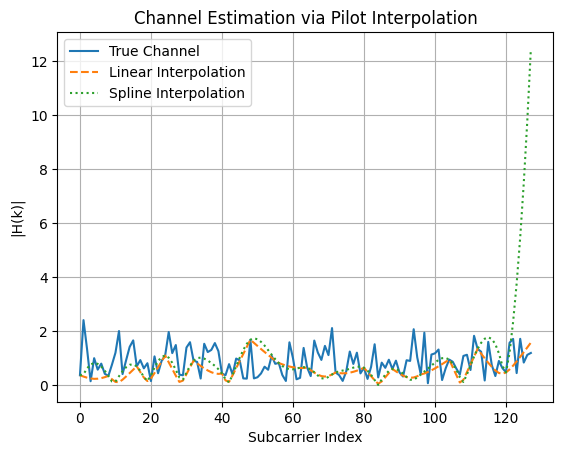

In [3]:
from scipy.interpolate import interp1d

N = 128
pilot_spacing = 8
pilot_indices = np.arange(0, N, pilot_spacing)
true_channel = (np.random.randn(N) + 1j*np.random.randn(N)) / np.sqrt(2)
pilot_values = true_channel[pilot_indices]

# Interpolation
linear_interp = interp1d(pilot_indices, pilot_values, kind='linear', fill_value="extrapolate")
spline_interp = interp1d(pilot_indices, pilot_values, kind='cubic', fill_value="extrapolate")
linear_est = linear_interp(np.arange(N))
spline_est = spline_interp(np.arange(N))

# Plot
plt.figure()
plt.plot(np.abs(true_channel), label="True Channel")
plt.plot(np.abs(linear_est), '--', label="Linear Interpolation")
plt.plot(np.abs(spline_est), ':', label="Spline Interpolation")
plt.title("Channel Estimation via Pilot Interpolation")
plt.xlabel("Subcarrier Index")
plt.ylabel("|H(k)|")
plt.legend()
plt.grid(True)
plt.savefig("Block2_channel_interpolation.png", dpi=300)
plt.show()

## Block 3: Channel Estimation Techniques

We compare LS and MMSE estimation using pilot symbols transmitted through Rayleigh + AWGN channel.

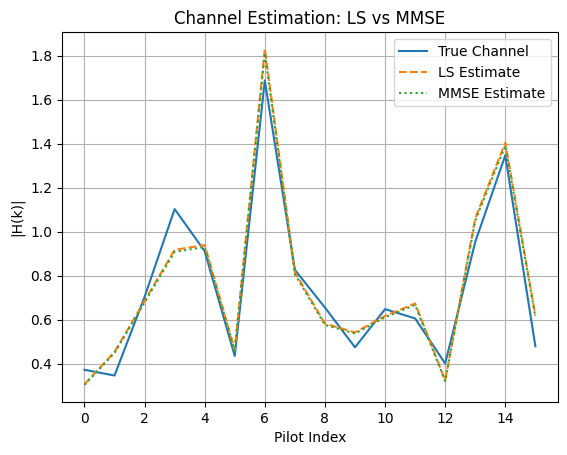

In [4]:
snr_db = 20
noise_power = 10 ** (-snr_db / 10)
X_p = np.ones(len(pilot_values))
Y_p = pilot_values + np.sqrt(noise_power) * (np.random.randn(len(pilot_values)) + 1j*np.random.randn(len(pilot_values)))

# LS Estimation
H_LS = Y_p / X_p

# MMSE Estimation
R_HH = np.eye(len(H_LS))
sigma2 = noise_power
H_MMSE = R_HH @ np.linalg.inv(R_HH + (sigma2 / np.abs(X_p)**2)[:, None] * np.eye(len(X_p))) @ H_LS

# Plot
plt.figure()
plt.plot(np.abs(pilot_values), label="True Channel")
plt.plot(np.abs(H_LS), '--', label="LS Estimate")
plt.plot(np.abs(H_MMSE), ':', label="MMSE Estimate")
plt.title("Channel Estimation: LS vs MMSE")
plt.xlabel("Pilot Index")
plt.ylabel("|H(k)|")
plt.legend()
plt.grid(True)
plt.savefig("Block3_ls_mmse_comparison.png", dpi=300)
plt.show()

## Block 4: Equalization Methods

We apply ZF and MMSE equalization to recover QAM symbols distorted by Rayleigh fading and noise.

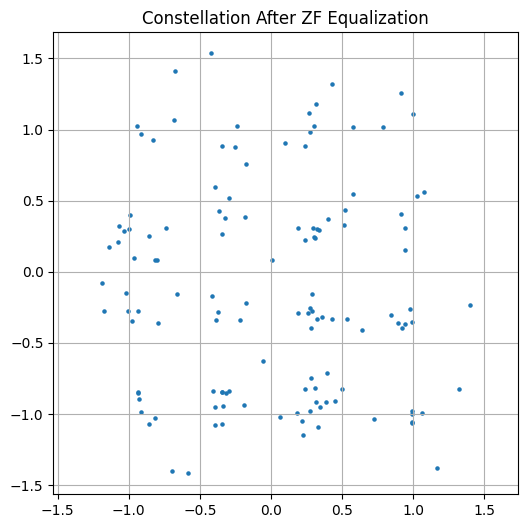

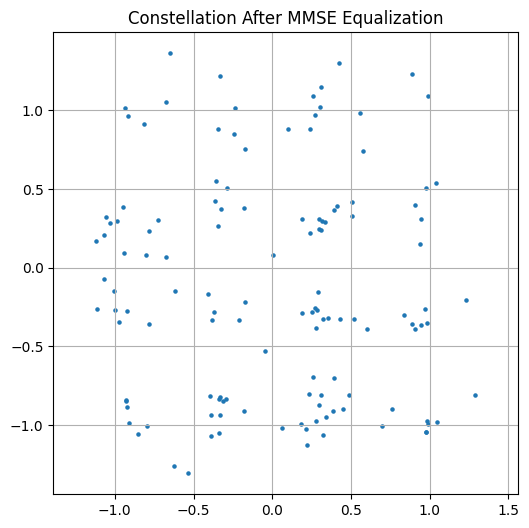

In [6]:
def qam_modulate(bits):
    real = 2 * (bits // 4) - 3
    imag = 2 * (bits % 4) - 3
    return (real + 1j * imag) / np.sqrt(10)

def qam_demodulate(symbols):
    real = np.round(np.real(symbols) * np.sqrt(10)).astype(int)
    imag = np.round(np.imag(symbols) * np.sqrt(10)).astype(int)
    real = np.clip((real + 3) // 2, 0, 3)
    imag = np.clip((imag + 3) // 2, 0, 3)
    return 4 * real + imag

data_bits = np.random.randint(0, 16, N)
symbols = qam_modulate(data_bits)
channel = (np.random.randn(N) + 1j*np.random.randn(N)) / np.sqrt(2)
rx = channel * symbols + np.sqrt(noise_power) * (np.random.randn(N) + 1j*np.random.randn(N))

# Equalization
eq_zf = rx / channel
eq_mmse = (np.conj(channel) / (np.abs(channel)**2 + noise_power)) * rx

# Plot ZF
plt.figure(figsize=(6,6))
plt.scatter(np.real(eq_zf), np.imag(eq_zf), s=5)
plt.title("Constellation After ZF Equalization")
plt.grid(True)
plt.axis("equal")
plt.savefig("Block4_constellation_zf.png", dpi=300)
plt.show()

# Plot MMSE
plt.figure(figsize=(6,6))
plt.scatter(np.real(eq_mmse), np.imag(eq_mmse), s=5)
plt.title("Constellation After MMSE Equalization")
plt.grid(True)
plt.axis("equal")
plt.savefig("Block4_constellation_mmse.png", dpi=300)
plt.show()

## Block 5: BER Analysis

We sweep SNR from 0 to 20 dB and compare BER performance of ZF and MMSE equalization.

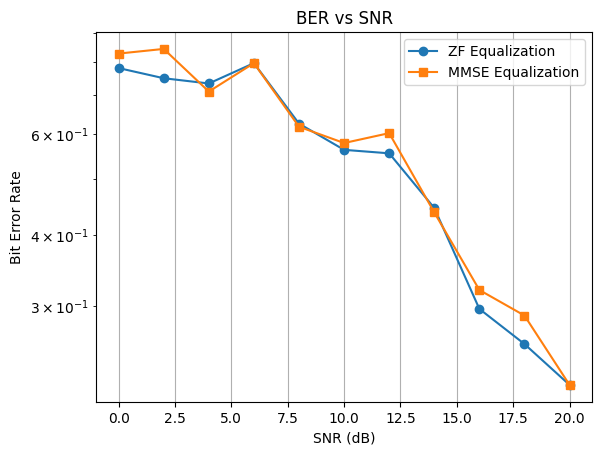

In [7]:
snr_range = np.arange(0, 21, 2)
ber_zf = []
ber_mmse = []

for snr in snr_range:
    noise_power = 10 ** (-snr / 10)
    bits = np.random.randint(0, 16, N)
    tx = qam_modulate(bits)
    h = (np.random.randn(N) + 1j*np.random.randn(N)) / np.sqrt(2)
    rx = h * tx + np.sqrt(noise_power) * (np.random.randn(N) + 1j*np.random.randn(N))

    # ZF
    eq_zf = rx / h
    rx_bits_zf = qam_demodulate(eq_zf)
    ber_zf.append(np.sum(bits != rx_bits_zf) / N)

    # MMSE
    eq_mmse = (np.conj(h) / (np.abs(h)**2 + noise_power)) * rx
    rx_bits_mmse = qam_demodulate(eq_mmse)
    ber_mmse.append(np.sum(bits != rx_bits_mmse) / N)

# Plot BER vs SNR
plt.figure()
plt.semilogy(snr_range, ber_zf, 'o-', label="ZF Equalization")
plt.semilogy(snr_range, ber_mmse, 's-', label="MMSE Equalization")
plt.title("BER vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate")
plt.grid(True)
plt.legend()
plt.savefig("Block5_ber_vs_snr.png", dpi=300)
plt.show()